In [177]:
# TO create the full_level csv

# import pandas as pd
# import os

# path = '../processed/'
# files = os.listdir(path)
# frames = []
# for file in files:
#     if 'level' in file:
#         file = pd.read_csv(f'{path}/{file}')
#         frames.append(file)

# full_level = pd.concat(frames, ignore_index=True)
# full_level['Datum'] = pd.to_datetime(full_level['Datum'])
# full_level['Tijd'] = pd.to_datetime(full_level['Tijd'])
# full_level['Tijd'] = full_level['Tijd'].dt.time
# full_level.sort_values(by=['Datum', 'Tijd'], inplace = True)
# full_level['Datum'] = full_level['Datum'].astype(str)
# full_level['Tijd'] = full_level['Tijd'].astype(str)
# full_level.reset_index(drop=True,inplace=True)

# full_level.to_csv('../processed/full_level.csv')


In [178]:
import pandas as pd
import os
import numpy as np

# create full level csv
path = '../processed/'
full_level = pd.read_csv('../processed/full_level.csv')


# Function to select all level data from one pump
def get_pump_level(pump: str, sample_time='1h')->pd.DataFrame:
    """Creates a dataframe with all level data for one pump"""

    pump_level = full_level.loc[:, full_level.columns.str.contains(f'{str(pump)}|Tijd|Datum')]

    pump_level['date+time'] = pump_level['Datum'] + ' ' + pump_level['Tijd']

    pump_level['date+time'] = pd.to_datetime(pump_level['date+time'])

    pump_level.set_index('date+time', drop=True, inplace=True)
    pump_level = pd.DataFrame(pump_level.resample(sample_time).mean())
    pump_level['level_diff'] = pump_level.diff()
    print('pump level done')
    return pump_level


# function to get all flow data from one pump
def get_flow_data(pump: str, sample_time='1h')->pd.DataFrame:
    """Creates data frame with all flow data for one pump"""
    files = os.listdir(path)
    
    frames = []
    for file in files:
        if 'flow' and pump in file:
            file = pd.read_csv(f'{path}/{file}')
            frames.append(file)
    
    flow_data = pd.concat(frames, ignore_index=True)
    flow_data['datumBeginMeting'].fillna(flow_data['dem'], inplace=True)
    flow_data['datumBeginMeting'] = pd.to_datetime(flow_data['datumBeginMeting'])
    flow_data.sort_values(by=['datumBeginMeting'], inplace=True)
    flow_data = flow_data[['datumBeginMeting', 'hstWaarde']].set_index('datumBeginMeting')
    flow_data = flow_data.resample(sample_time).mean()
    print('flow data done')
    return flow_data



def pump_flow_level(pump: str, sample_time='1h'):
    """"Combines both level and flow dataframes to one dataframe"""
    
    dct = {'Helftheuvel': ['003', '301'], 'Engelerschans': ['004', 'FIT201'], 'Maaspoort': ['006', '501'],
           'Rompert': ['005', '501'], 'Oude Engelenseweg': ['002', '401']}

    if pump not in dct.keys():
        return f'Pump name not recognized, try one of these {dct.keys()}'
    
    df_level = get_pump_level(dct[pump][0], sample_time)
    df_flow = get_flow_data(dct[pump][1], sample_time)
    
    df_flow_level = pd.merge(df_level, df_flow, how='inner', left_index=True, right_index=True)
    return df_flow_level

In [234]:
def get_in_flow_approximation(pump: str, sample_time="1T"):
    """
    Calculates the cycle length and sums the outflow in one cycle to finally devide it by the length, 
    giving the average over the cycle, then smoothening it with 100 rolling
    """
    
    df_pump = pump_flow_level(pump, sample_time="1T")
    
    df_concat = df_pump.copy()
    df_concat = df_concat.fillna(method='pad')

    df_concat['pump_cycle_start'] = False
    df_concat['next_hstWaarde'] = df_concat['hstWaarde'].shift(-1)

    df_test = df_concat.copy()
    df_test['zscore'] = abs((df_test['hstWaarde'] - df_test['hstWaarde'].mean())/df_test['hstWaarde'].std(ddof=0))
    df_test = df_test[df_test['zscore'] < 1.65]
    overflow_amount = int(round(df_test['hstWaarde'].max()))

    df_concat.loc[((df_concat['hstWaarde'] < 5) & 
                   (df_concat['next_hstWaarde'] > 5)) | 
                  ((df_concat['hstWaarde'] > 1608) & 
                   (df_concat['next_hstWaarde'] > df_concat['hstWaarde'])), 'pump_cycle_start'] = True
    df_concat['just_turned_on_debug'] = np.nan
    df_concat.loc[df_concat['pump_cycle_start'] == True, 'just_turned_on_debug'] = df_concat['hstWaarde']

    df_concat['hstWaarde_sum'] = df_concat['hstWaarde'].cumsum()
    df_concat['prev_hstWaarde_sum'] = np.nan

    df_concat.loc[df_concat['pump_cycle_start'] == True, 'prev_hstWaarde_sum'] = df_concat['hstWaarde_sum'] 
    df_concat['prev_hstWaarde_sum'] = df_concat['prev_hstWaarde_sum'].ffill()
    df_concat['prev_hstWaarde_sum'] = df_concat['prev_hstWaarde_sum'].shift(1)

    df_concat['counter'] = range(1, len(df_concat) + 1)
    df_concat['prev_counter'] = np.nan
    df_concat.loc[df_concat['pump_cycle_start'] == True, 'prev_counter'] = df_concat['counter'] 
    df_concat['prev_counter'] = df_concat['prev_counter'].ffill()
    df_concat['prev_counter'] = df_concat['prev_counter'].shift(1)

    df_concat['cycle_flow_mean'] = np.nan
    df_concat.loc[df_concat['pump_cycle_start'] == True, 'cycle_flow_mean'] = (df_concat['hstWaarde_sum'] - df_concat['prev_hstWaarde_sum'])/(df_concat['counter'] - df_concat['prev_counter'])
    df_concat['cycle_flow_mean'] = df_concat['cycle_flow_mean'].ffill()
    df_concat['SMA_cycle_flow'] = df_concat.loc[:,'cycle_flow_mean'].rolling(window=100).mean().shift(-100)
    
    df_pump['flow_in'] = df_concat['SMA_cycle_flow']
    return df_pump

In [200]:
pumps = ['Helftheuvel', 'Engelerschans', 'Maaspoort', 'Rompert', 'Oude Engelenseweg']
for pump in pumps:
    pump_flow = get_in_flow_approximation(pump)
    pump_flow.to_csv(f"../processed/pump_in_flow_appr_{pump}.csv")

<ipython-input-178-140b38b5716a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pump_level['date+time'] = pump_level['Datum'] + ' ' + pump_level['Tijd']
<ipython-input-178-140b38b5716a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pump_level['date+time'] = pd.to_datetime(pump_level['date+time'])


pump level done
flow data done
pump level done
flow data done
pump level done
flow data done
pump level done
flow data done
pump level done
flow data done


In [ ]:
# OLD
# df_concat['pump_turned_on'] = np.nan
# df_concat['cm_diff_1min'] = df_concat['003: Helftheuvelweg Niveau (cm)'].diff(-1) * -1
# df_concat['cm_diff_2min'] = df_concat['003: Helftheuvelweg Niveau (cm)'].diff(-2) * -1
# df_concat['cm_diff_3min'] = df_concat['003: Helftheuvelweg Niveau (cm)'].diff(-3) * -1
# df_concat['cm_diff_4min'] = df_concat['003: Helftheuvelweg Niveau (cm)'].diff(-4) * -1
# df_concat['cm_diff_5min'] = df_concat['003: Helftheuvelweg Niveau (cm)'].diff(-5) * -1
# df_concat['cm_diff_mean'] = (df_concat['cm_diff_5min'] + df_concat['cm_diff_4min'] + df_concat['cm_diff_3min'] + df_concat['cm_diff_2min'] + df_concat['cm_diff_1min'])/5
# df_concat.loc[df_concat['cm_diff_mean'] < -10, 'pump_turned_on'] = True
# df_concat.loc[(df_concat['cm_diff_mean'] > 10) & (df_concat['cm_diff_1min'] > 0) & (df_concat['cm_diff_2min'] > 0), 'pump_turned_on'] = False
# df_concat['pump_turned_on'] = df_concat['pump_turned_on'].ffill()
# df_concat['turned_on_debug'] = np.nan
# df_concat['turned_off_debug'] = np.nan
# df_concat['just_turned_on_debug'] = np.nan
# df_concat.loc[df_concat['pump_turned_on'] == True, 'turned_on_debug'] = df_concat['hstWaarde']
# df_concat.loc[df_concat['pump_turned_on'] == False, 'turned_off_debug'] = df_concat['hstWaarde']
# df_concat['prev_pump_on'] = df_concat['pump_on'].shift(-1)
# df_concat['pump_just_on'] = False
# df_concat.loc[(df_concat['prev_pump_on'] == False) & (df_concat['pump_on'] == True), 'pump_just_on'] = True
# df_concat.loc[df_concat['pump_just_on'] == True, 'just_turned_on_debug'] = df_concat['hstWaarde']

In [223]:
df = get_in_flow_approximation('Maaspoort')

<ipython-input-178-140b38b5716a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pump_level['date+time'] = pump_level['Datum'] + ' ' + pump_level['Tijd']
<ipython-input-178-140b38b5716a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pump_level['date+time'] = pd.to_datetime(pump_level['date+time'])


pump level done
flow data done


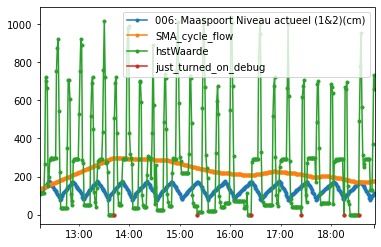

In [233]:
df.iloc[-700:-300].plot(None, ['006: Maaspoort Niveau actueel (1&2)(cm)', 'hstWaarde', 'just_turned_on_debug'], style=".-")